In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [249]:
df = pd.read_csv('insurance.csv')
df.head()



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [251]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [252]:
from sklearn.preprocessing import LabelEncoder
categorical_features = ['sex', 'smoker', 'region']
df[categorical_features] = df[categorical_features].apply(LabelEncoder().fit_transform)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [253]:
df[['age', 'bmi']].describe()



,age,bmi
count,1338.000000,1338.000000
mean,39.207025,30.663397
std,14.049960,6.098187
min,18.000000,15.960000
25%,27.000000,26.296250
50%,39.000000,30.400000
75%,51.000000,34.693750
max,64.000000,53.130000


In [254]:
# Create age ranges and label encode them
df['age_range'] = pd.cut(df['age'], 
                        bins=[0, 20, 30, 40, 50, 60, float('inf')],
                        labels=['0-20', '21-30', '31-40', '41-50', '51-60', '60+'])

# Apply label encoding to the new age_range column
le = LabelEncoder()
df['age_range'] = le.fit_transform(df['age_range'])



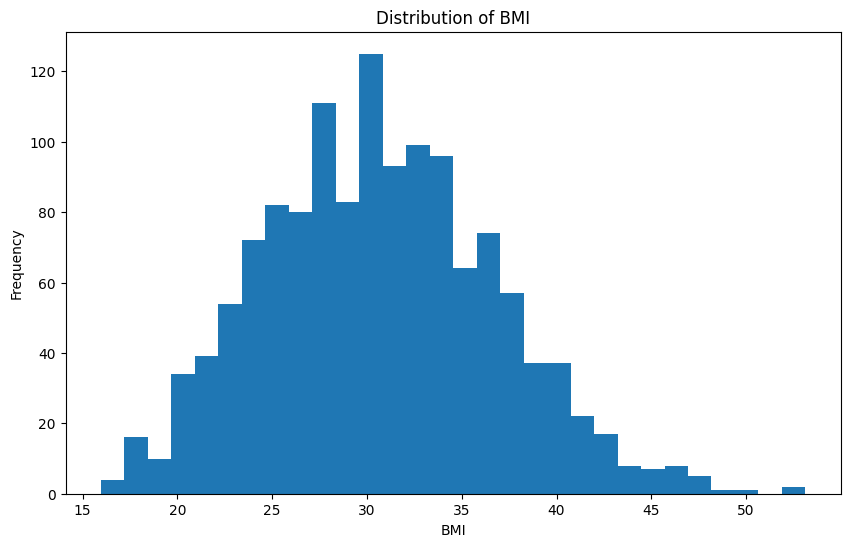

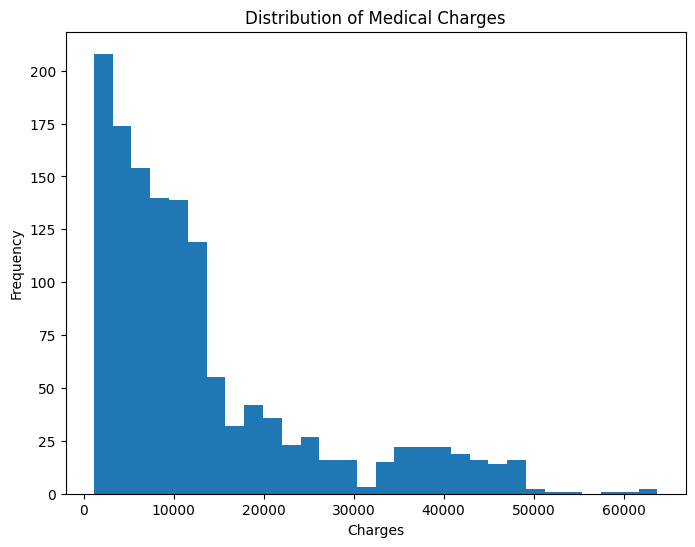

In [255]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df['bmi'], bins=30)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,6))
plt.hist(df['charges'], bins=30)
plt.title('Distribution of Medical Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()


In [256]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['charges'] = scaler.fit_transform(df[['charges']])


In [257]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [258]:
X = df.drop('charges', axis=1)
y = df['charges']

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)


torch.manual_seed(42)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [259]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1070, 7]),
 torch.Size([268, 7]),
 torch.Size([1070]),
 torch.Size([268]))

In [260]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(7, 64)
        self.layer_2 = nn.Linear(64, 36)
        self.layer_3 = nn.Linear(36, 16)
        self.layer_4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        z = self.relu(self.layer_1(x))
        z = self.relu(self.layer_2(z))
        z = self.relu(self.layer_3(z))
        z = self.layer_4(z)
        return z
    
model = NeuralNetwork().to(device)

In [261]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2890,  0.3137, -0.0885,  0.3472, -0.0828,  0.0763, -0.1840],
                      [ 0.2220,  0.3332, -0.2773,  0.3285,  0.0707,  0.2792,  0.0512],
                      [ 0.1822, -0.0534,  0.2914,  0.0559, -0.1764,  0.0963, -0.1741],
                      [-0.0443, -0.1535,  0.2507, -0.2984, -0.1742, -0.1067, -0.2273],
                      [ 0.0357, -0.3733,  0.3413, -0.3211,  0.2918,  0.0629, -0.1227],
                      [ 0.2336,  0.0589,  0.3054,  0.0413, -0.1192,  0.1016, -0.1025],
                      [ 0.1591,  0.3375,  0.2185, -0.1652,  0.2182,  0.0676,  0.1919],
                      [-0.2304, -0.3742, -0.1460, -0.2899,  0.3101,  0.1089,  0.1566],
                      [ 0.1195, -0.0066,  0.2958, -0.2685,  0.0238, -0.2580,  0.1165],
                      [-0.1302,  0.1158, -0.0787,  0.3135, -0.2240, -0.2254, -0.2254],
                      [ 0.3400,  0.1260,  0.3637, -0.3119, -0.3749, -0.2957, -0.2543],
           

In [262]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [263]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


In [264]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

train_loss = []
t_loss = []

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    

    loss = loss_fn(y_pred.squeeze(), y_train)
    train_loss.append(loss.detach().cpu().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.inference_mode():
        y_pred_test = model(X_test)
        test_loss = loss_fn(y_pred_test.squeeze(), y_test)
        t_loss.append(test_loss.detach().cpu().numpy())
        

    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}')


Epoch 0 | Train Loss: 2.1854 | Test Loss: 1.6593
Epoch 100 | Train Loss: 0.9132 | Test Loss: 0.9627
Epoch 200 | Train Loss: 0.4152 | Test Loss: 0.4209
Epoch 300 | Train Loss: 0.2145 | Test Loss: 0.1982
Epoch 400 | Train Loss: 0.1863 | Test Loss: 0.1684
Epoch 500 | Train Loss: 0.1732 | Test Loss: 0.1559
Epoch 600 | Train Loss: 0.1610 | Test Loss: 0.1473
Epoch 700 | Train Loss: 0.1566 | Test Loss: 0.1449
Epoch 800 | Train Loss: 0.1510 | Test Loss: 0.1416
Epoch 900 | Train Loss: 0.1488 | Test Loss: 0.1425


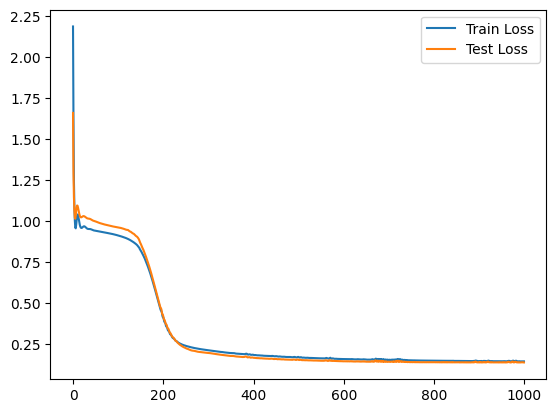

In [265]:
plt.plot(train_loss, label='Train Loss')
plt.plot(t_loss, label='Test Loss')
plt.legend()
plt.show()

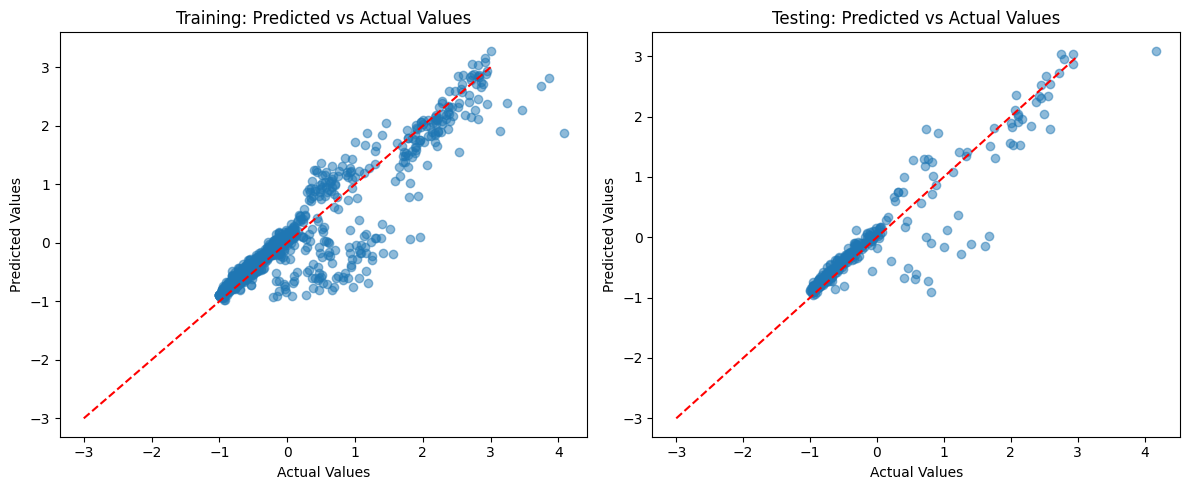

In [266]:
# Get predictions
model.eval()
with torch.inference_mode():
    y_pred_train = model(X_train).cpu().numpy()
    y_pred_test = model(X_test).cpu().numpy()
    y_train_cpu = y_train.cpu().numpy()
    y_test_cpu = y_test.cpu().numpy()

# Create scatter plot
plt.figure(figsize=(12, 5))

# Training data plot
plt.subplot(1, 2, 1)
plt.scatter(y_train_cpu, y_pred_train, alpha=0.5)
plt.plot([-3, 3], [-3, 3], 'r--')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training: Predicted vs Actual Values')

# Testing data plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_cpu, y_pred_test, alpha=0.5)
plt.plot([-3, 3], [-3, 3], 'r--')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Testing: Predicted vs Actual Values')

plt.tight_layout()
plt.show()